# Celltype auto annotation with SCSA
Single-cell transcriptomics allows the analysis of thousands of cells in a single experiment and the identification of novel cell types, states and dynamics in a variety of tissues and organisms. Standard experimental protocols and analytical workflows have been developed to create single-cell transcriptomic maps from tissues.

This tutorial focuses on how to interpret this data to identify cell types, states, and other biologically relevant patterns with the goal of creating annotated cell maps.

Paper: [SCSA: A Cell Type Annotation Tool for Single-Cell RNA-seq Data](https://doi.org/10.3389/fgene.2020.00490)

Code: https://github.com/bioinfo-ibms-pumc/SCSA

Colab_Reproducibility：https://colab.research.google.com/drive/1BC6hPS0CyBhNu0BYk8evu57-ua1bAS0T?usp=sharing

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA can't be used in rare celltype annotations
  </p>
</div>

![scsa](https://www.frontiersin.org/files/Articles/524690/fgene-11-00490-HTML/image_m/fgene-11-00490-g001.jpg)

In [1]:
# !pip install omicverse
# !pip install torch_geometric
# !pip install pymde

**You must restart the program(ctrl+m+.) in order to import the accurate version of matplotlib.**

In [2]:
import omicverse as ov
print(f'omicverse version:{ov.__version__}')
import scanpy as sc
print(f'scanpy version:{sc.__version__}')
ov.ov_plot_set()
import anndata as ad
import pandas as pd


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.7, Tutorials: https://omicverse.readthedocs.io/
omicverse version:1.5.7
scanpy version:1.9.6


## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


In [3]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [4]:
adata_a = sc.read_10x_mtx(
    'data/PBMC_Doners/frozen_pbmc_donor_a_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-PBMC_Doners-frozen_pbmc_donor_a_filtered_gene_bc_matrices-filtered_matrices_mex-hg19-matrix.h5ad


In [5]:
adata_b = sc.read_10x_mtx(
    'data/PBMC_Doners/frozen_pbmc_donor_b_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-PBMC_Doners-frozen_pbmc_donor_b_filtered_gene_bc_matrices-filtered_matrices_mex-hg19-matrix.h5ad


In [6]:
adata_c = sc.read_10x_mtx(
    'data/PBMC_Doners/frozen_pbmc_donor_c_filtered_gene_bc_matrices/filtered_matrices_mex/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-PBMC_Doners-frozen_pbmc_donor_c_filtered_gene_bc_matrices-filtered_matrices_mex-hg19-matrix.h5ad


In [7]:
adata_a.obs['donor'] = 'A'
adata_b.obs['donor'] = 'B'
adata_c.obs['donor'] = 'C'

In [8]:
adata = ad.concat([adata_a, adata_b, adata_c])

In [9]:
adata

AnnData object with n_obs × n_vars = 20202 × 32738
    obs: 'donor'

## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation.

But if you want to experience step-by-step preprocessing, we also provide more detailed preprocessing steps here, please refer to our [preprocess chapter](https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_preprocess/) for a detailed explanation.

We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [10]:
#adata=ov.single.scanpy_lazy(adata)

#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

#Neighbourhood graph construction
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

#clusters
sc.tl.leiden(adata)

#Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 20202
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 16161 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 34.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.7%
    Scrublet finished (0:00:14)
Cells retained after scrublet: 19941, 261 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tr

AnnData object with n_obs × n_vars = 19594 × 2000
    obs: 'donor', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'leiden'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` or `'panglaodb'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/41369037) or [Google Drive](https://drive.google.com/drive/folders/1pqyuCp8mTXDFRGUkX8iDdPAg45JHvheF?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [11]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='cellmarker',
                          tissue='All',
)

......Loading dataset from temp/pySCSA_2023_v2_plus.db


In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden. if you are using louvain, please change it. And, we will annotate all clusters, if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format.

`rank_rep` means the `sc.tl.rank_genes_groups(adata, clustertype, method='wilcoxon')`, if we provided the `rank_genes_groups` in adata.uns, `rank_rep` can be set as `False`

In [12]:
anno=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:11)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 81
Other Gene number: 3858
Cluster 1 Gene number: 141
Other Gene number: 3868
Cluster 10 Gene number: 119
Other Gene number: 3867
Cluster 11 Gene number: 57
Other Gene number: 3871
Cluster 12 Gene number: 165
Other Gene number: 3869
Cluster 13 Gene number: 1552
Other Gene number: 3729
Cluster 14 Gene number: 183
Other Gene number: 3866
Cluster 15 Gene number: 1497
Other Gene number: 3805
Cluster 16 Gene number: 691
Other Gene number: 3830
Cluster 17 Gene number: 2892
Other Gene number: 2835
Cluster 18 Gene number: 851
Other Gene number: 3789
Cluster 2 Gene number: 233
O

We can query only the better annotated results

In [13]:
scsa.cell_auto_anno(adata,key='scsa_celltype_cellmarker')

...cell type added to scsa_celltype_cellmarker on obs of anndata


We can also use `panglaodb` as target to annotate the celltype

In [14]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='panglaodb',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'

)

In [15]:
res=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:11)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 81
Other Gene number: 1295
Cluster 1 Gene number: 141
Other Gene number: 1298
Cluster 10 Gene number: 119
Other Gene number: 1296
Cluster 11 Gene number: 57
Other Gene number: 1299
Cluster 12 Gene number: 165
Other Gene number: 1296
Cluster 13 Gene number: 1552
Other Gene number: 1246
Cluster 14 Gene number: 183
Other Gene number: 1293
Cluster 15 Gene number: 1497
Other Gene number: 1272
Cluster 16 Gene number: 691
Other Gene number: 1267
Cluster 17 Gene number: 2892
Other Gene number: 1117
Cluster 18 Gene number: 851
Other Gene number: 1268
Cluster 2 Gene number: 233
O

We can query only the better annotated results

In [16]:
scsa.cell_anno_print()

Cluster:0	Cell_type:T Cells|T Memory Cells	Z-score:3.907|2.986
Cluster:1	Cell_type:NK Cells|T Cells	Z-score:3.545|2.913
Cluster:2	Cell_type:B Cells Naive|B Cells Memory	Z-score:4.762|4.486
Cluster:3	Cell_type:T Memory Cells|T Cells	Z-score:3.047|2.692
Cluster:4	Cell_type:T Cells|T Memory Cells	Z-score:4.095|3.044
Nice:Cluster:5	Cell_type:B Cells	Z-score:-0.964
Cluster:6	Cell_type:T Cells|T Helper Cells	Z-score:3.104|2.594
Cluster:7	Cell_type:Monocytes|Macrophages	Z-score:3.558|2.978
Cluster:8	Cell_type:Monocytes|Macrophages	Z-score:4.12|3.027
Cluster:9	Cell_type:NK Cells|Gamma Delta T Cells	Z-score:4.122|2.622
Cluster:10	Cell_type:T Cells|NK Cells	Z-score:3.94|2.464
Cluster:11	Cell_type:NK Cells|T Cells	Z-score:3.186|3.07
Cluster:12	Cell_type:NK Cells|T Cells	Z-score:3.285|2.713
Cluster:13	Cell_type:Monocytes|Macrophages	Z-score:3.976|3.171
Cluster:14	Cell_type:NK Cells|Decidual Cells	Z-score:3.914|2.579
Cluster:15	Cell_type:Monocytes|Dendritic Cells	Z-score:3.519|3.51
Cluster:16	Cell_

In [17]:
scsa.cell_auto_anno(adata,key='scsa_celltype_panglaodb')

...cell type added to scsa_celltype_panglaodb on obs of anndata


Here, we introduce the dimensionality reduction visualisation function `ov.utils.embedding`, which is similar to `scanpy.pl.embedding`, except that when we set `frameon='small'`, we scale the axes to the bottom-left corner and scale the colourbar to the bottom-right corner.

- adata: the anndata object
- basis: the visualized embedding stored in adata.obsm
- color: the visualized obs/var
- legend_loc: the location of legend, if you set None, it will be visualized in right.
- frameon: it can be set `small`, False or None
- legend_fontoutline: the outline in the text of legend.
- palette: Different categories of colours, we have a number of different colours preset in omicverse, including `ov.utils.palette()`, `ov.utils.red_color`, `ov.utils.blue_color`, `ov.utils.green_color`, `ov. utils.orange_color`. The preset colours can help you achieve a more beautiful visualisation.

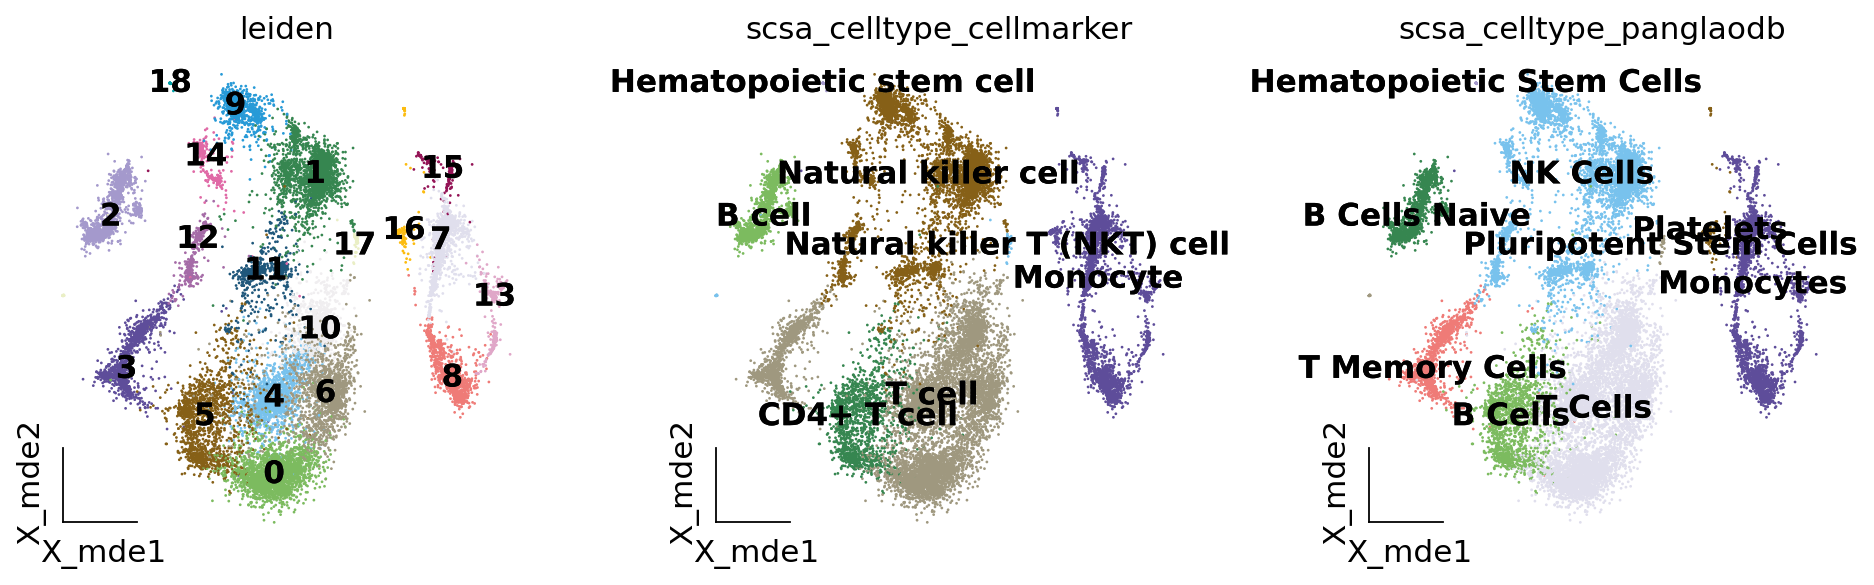

In [18]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['leiden','scsa_celltype_cellmarker','scsa_celltype_panglaodb'],
                   legend_loc='on data',
                   frameon='small',
                   legend_fontoutline=0.01,
                   palette=ov.utils.palette(),
                   save='SCSA_cellType_annotation.png',
                
                  )

If you want to draw stacked histograms of cell type proportions, you first need to colour the groups you intend to draw using `ov.utils.embedding`. Then use `ov.utils.plot_cellproportion` to specify the groups you want to plot, and you can see a plot of cell proportions in the different groups

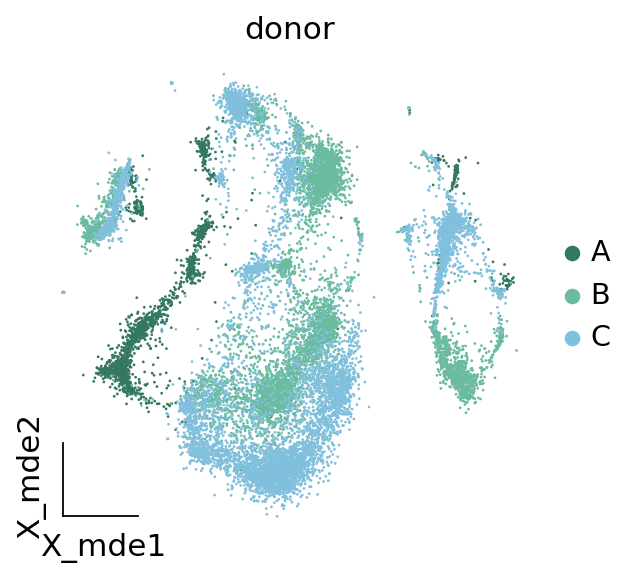

In [19]:
#Randomly designate the first 1000 cells as group B and the rest as group A
# adata.obs['group']='A'
# adata.obs.loc[adata.obs.index[:1000],'group']='B'
#Colored
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['donor'],
                   frameon='small',legend_fontoutline=2,
                   palette=ov.utils.blue_palette(),
                   save='Donor_cells.png',
                  )

(<Figure size 160x320 with 1 Axes>,
 <AxesSubplot: xlabel='Donor', ylabel='Cells per Stage'>)

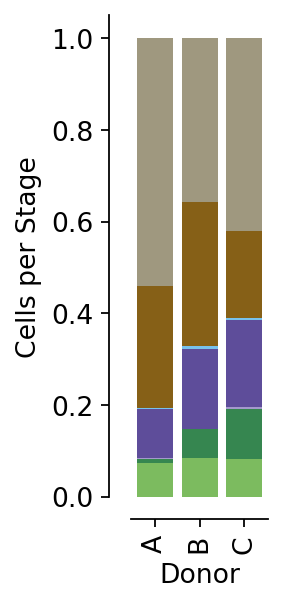

In [20]:
ov.utils.plot_cellproportion(adata=adata,celltype_clusters='scsa_celltype_cellmarker',
                    visual_clusters='donor',
                    visual_name='Donor',figsize=(2,4))

Of course, we also provide another downscaled visualisation of the graph using `ov.utils.plot_embedding_celltype`

(<Figure size 960x800 with 2 Axes>,
 [<AxesSubplot: xlabel='X_mde1', ylabel='X_mde2'>, <AxesSubplot: >])

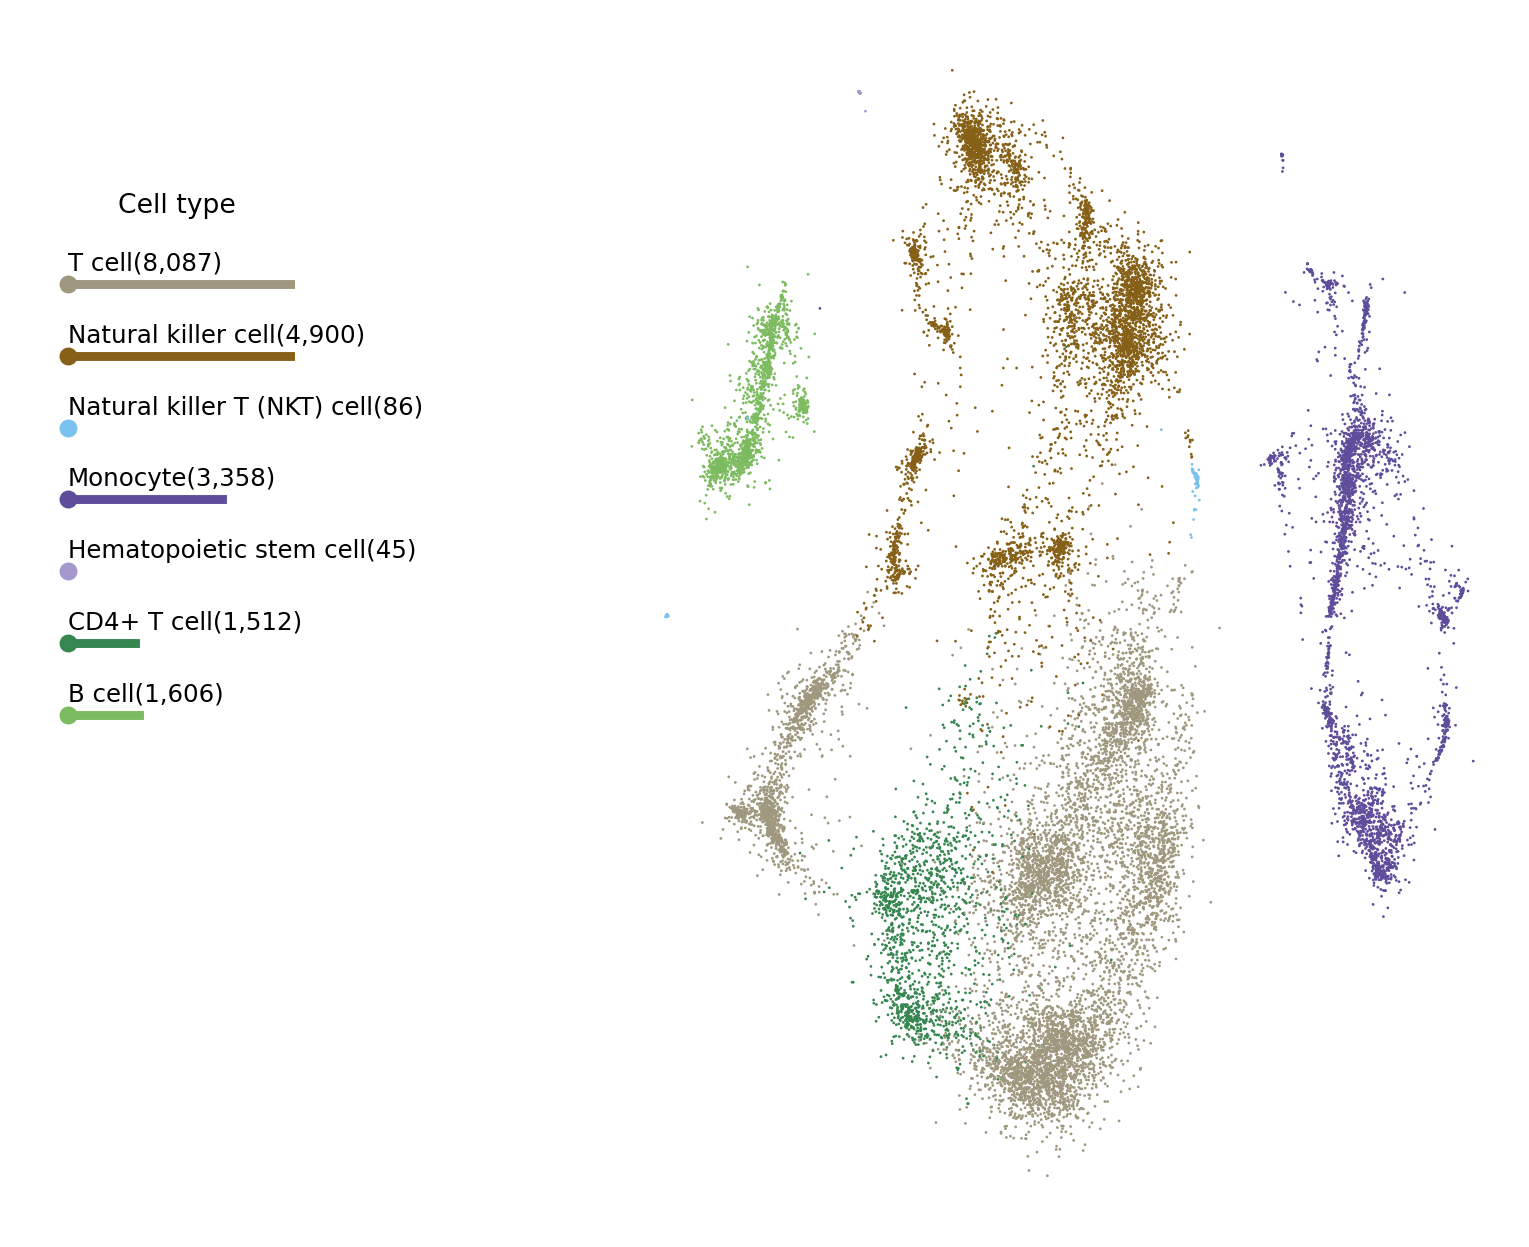

In [21]:
ov.utils.plot_embedding_celltype(adata,figsize=(12, 10),basis='X_mde',
                            celltype_key='scsa_celltype_cellmarker',
                            title='            Cell type',
                            celltype_range=(2,6),
                            embedding_range=(4,10),)

We calculated the ratio of observed to expected cell numbers (Ro/e) for each cluster in different tissues to quantify the tissue preference of each cluster (Guo et al., 2018; Zhang et al., 2018). The expected cell num- bers for each combination of cell clusters and tissues were obtained from the chi-square test. One cluster was identified as being enriched in a specific tissue if Ro/e>1.

The Ro/e function was wrote by `Haihao Zhang`.

In [22]:
roe=ov.utils.roe(adata, sample_key='donor', cell_type_key='scsa_celltype_cellmarker')

chi2: 849.1690948780837, dof: 12, pvalue: 4.688630886920442e-174


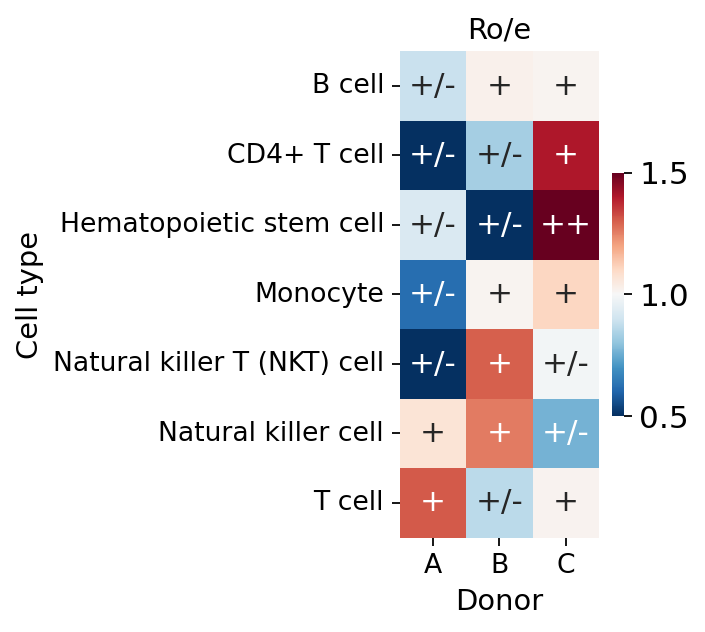

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,4))

transformed_roe = roe.copy()
transformed_roe = transformed_roe.applymap(
    lambda x: '+++' if x >= 2 else ('++' if x >= 1.5 else ('+' if x >= 1 else '+/-')))

sns.heatmap(roe, annot=transformed_roe, cmap='RdBu_r', fmt='',
            cbar=True, ax=ax,vmin=0.5,vmax=1.5,cbar_kws={'shrink':0.5})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Donor',fontsize=13)
plt.ylabel('Cell type',fontsize=13)
plt.title('Ro/e',fontsize=13)
plt.savefig('assets/figures/CellType_Donor_ratio.png')

## Cell annotate manually

In order to compare the accuracy of our automatic annotations, we will here use marker genes to manually annotate the cluster and compare the accuracy of the pySCSA and manual.

We need to prepare a marker's dict at first

In [24]:
res_marker_dict={
    'Megakaryocyte':['ITGA2B','ITGB3'],
    'Dendritic cell':['CLEC10A','IDO1'],
    'Monocyte' :['S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1',],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],

}

We then calculated the expression of marker genes in each cluster and the fraction

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:10)
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Megakaryocyte, Dendritic cell, Monocyte, etc.


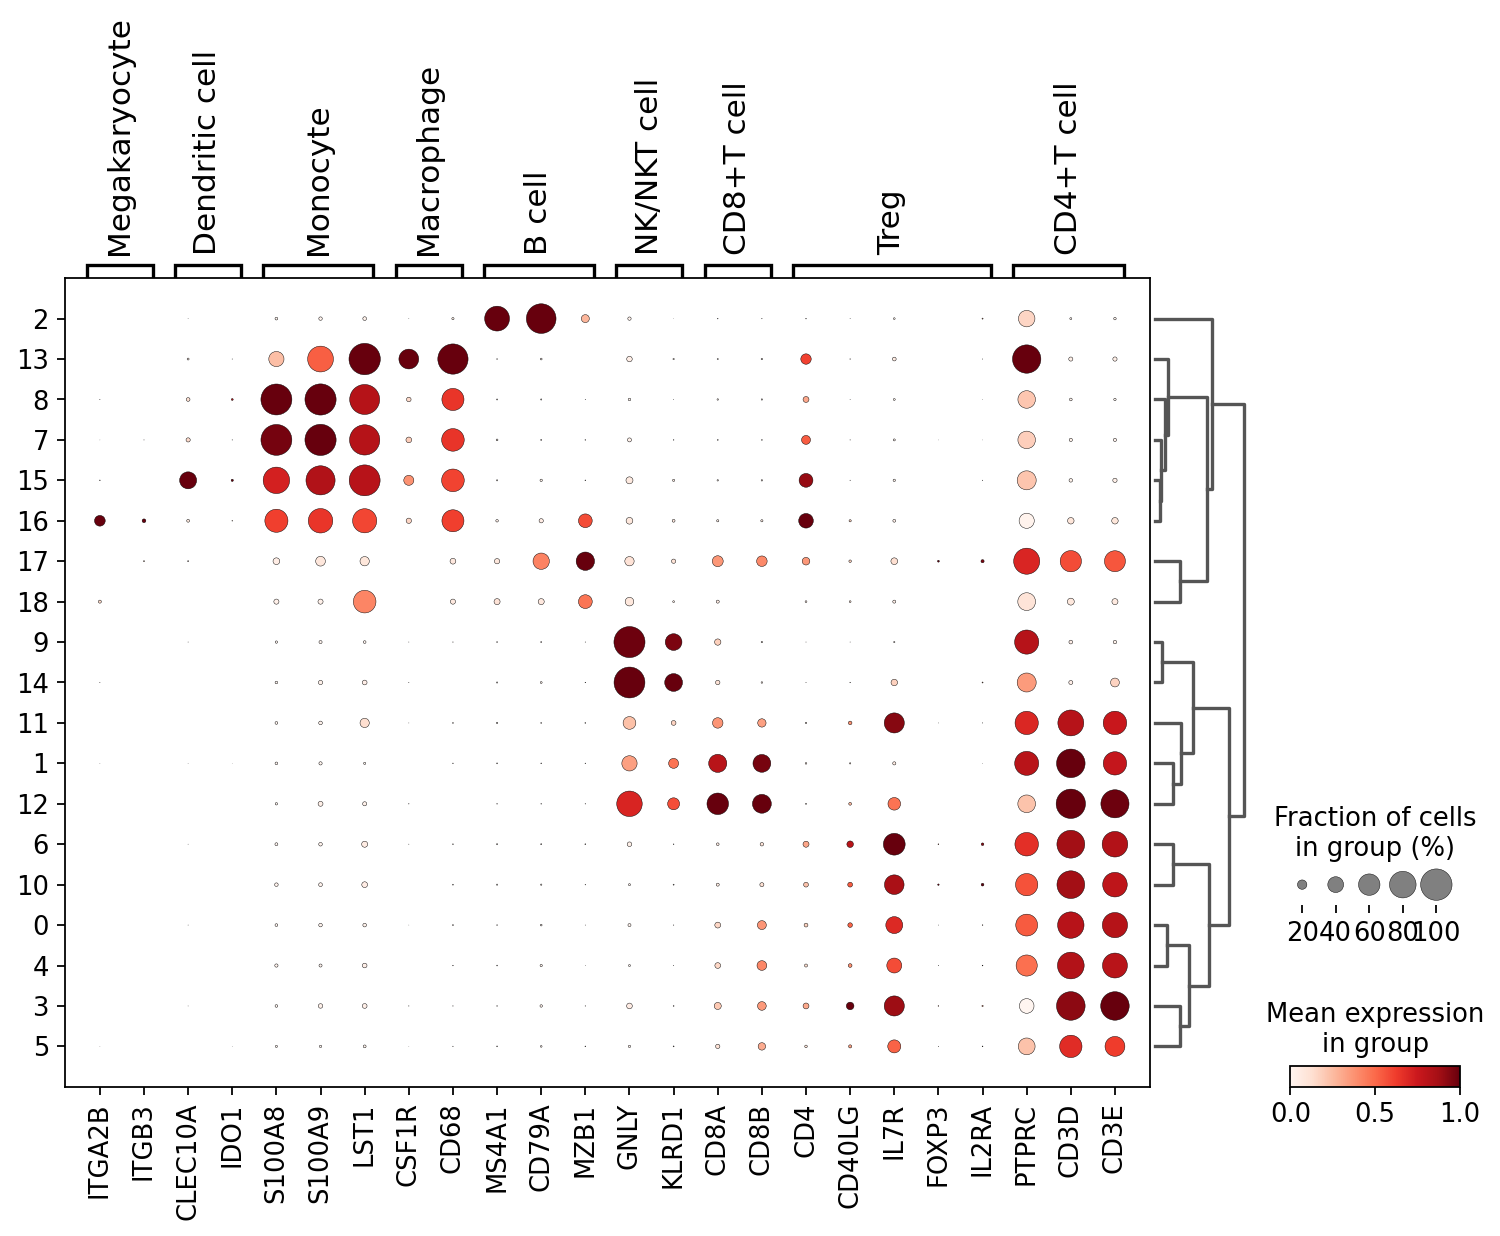

In [25]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden',
              dendrogram=True,standard_scale='var')

Based on the dotplot, we name each cluster according `ov.single.scanpy_cellanno_from_dict`

In [26]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'T cell',
     '1': 'T cell',
     '2': 'Monocyte',#Germ-cell(Oid)
     '3': 'B cell',#Germ-cell(Oid)
     '4': 'T cell',
     '5': 'Macrophage',
     '6': 'NKT cells',
     '7': 'T cell',
    '8':'Monocyte',
    '9':'Dendritic cell',
    '10':'Megakaryocyte',

}
ov.single.scanpy_cellanno_from_dict(adata,anno_dict=cluster2annotation,
                                       clustertype='leiden')

...cell type added to major_celltype on obs of anndata


## Compare the pySCSA and Manual

We can see that the auto-annotation results are almost identical to the manual annotation, the only difference is between monocyte and macrophages, but in the previous auto-annotation results, pySCSA gives the option of `monocyte|macrophage`, so it can be assumed that pySCSA performs better on the pbmc3k data

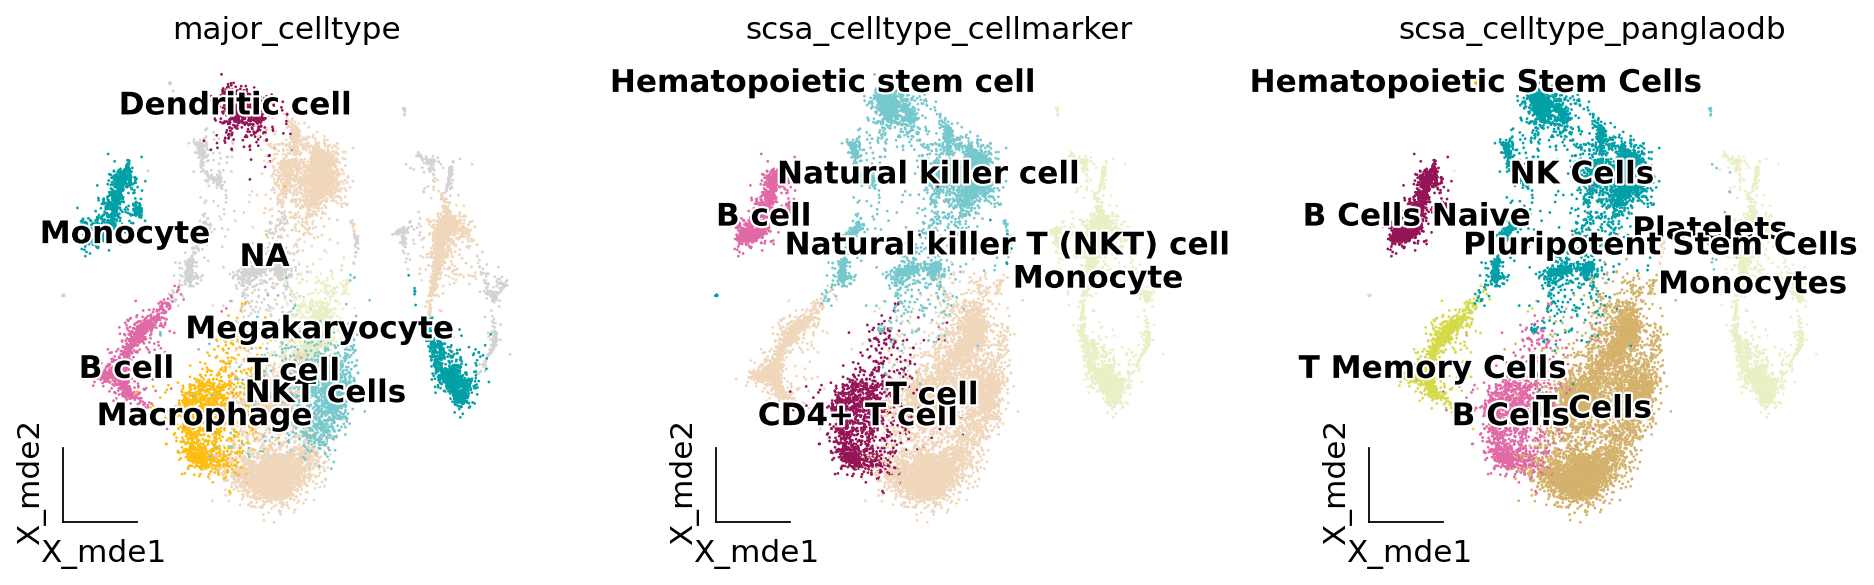

In [27]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['major_celltype','scsa_celltype_cellmarker', 'scsa_celltype_panglaodb'],
                   legend_loc='on data', frameon='small',legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

We can use `get_celltype_marker` to obtain the marker of each celltype

In [28]:
marker_dict=ov.single.get_celltype_marker(adata,clustertype='scsa_celltype_cellmarker')
marker_dict.keys()

...get cell type marker
ranking genes
    finished (0:00:10)


dict_keys(['B cell', 'CD4+ T cell', 'Hematopoietic stem cell', 'Monocyte', 'Natural killer T (NKT) cell', 'Natural killer cell', 'T cell'])

In [29]:
marker_dict['B cell']

array(['CD74', 'HLA-DRA', 'CD79A', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DRB1',
       'CD79B', 'CD37', 'HLA-DQB1', 'MS4A1', 'HLA-DQA1', 'HLA-DRB5',
       'HLA-DQA2'], dtype=object)

## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [30]:
scsa.get_model_tissue()

Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:298       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                          

In [31]:
samp_adata = adata.copy()

In [32]:
sc.tl.rank_genes_groups(samp_adata, groupby='donor', method='t-test')

ranking genes
    finished (0:00:00)


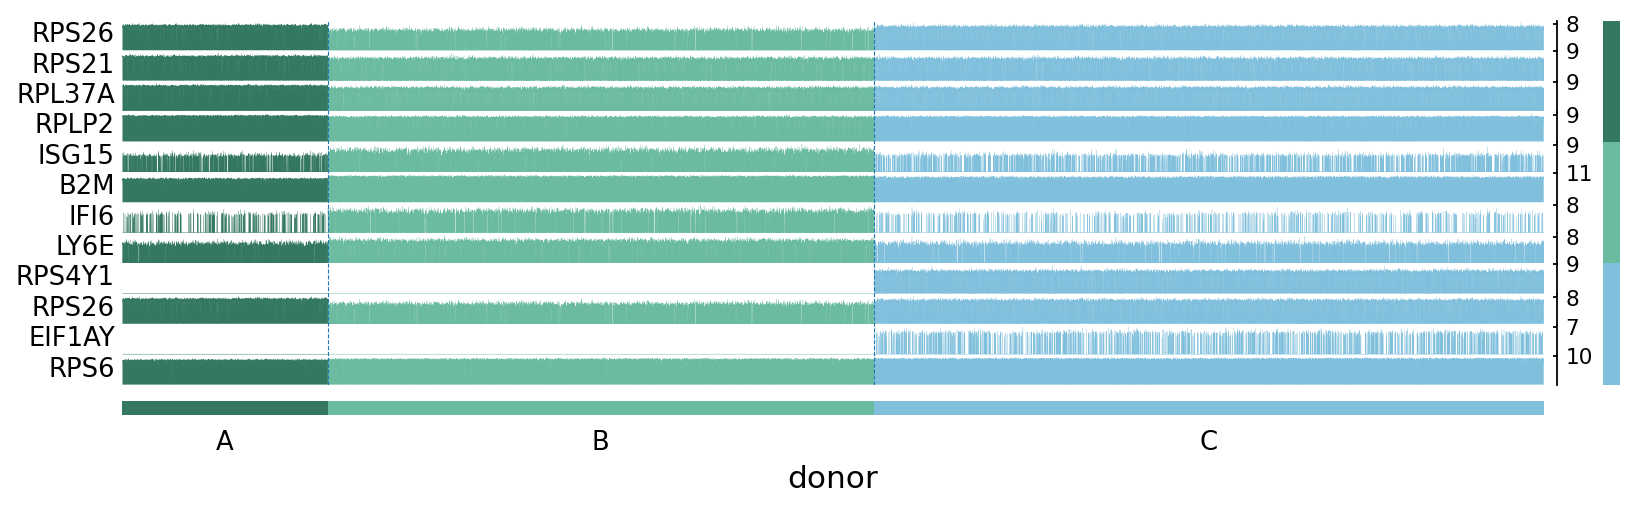

In [33]:
sc.pl.rank_genes_groups_tracksplot(samp_adata, dendrogram=False, n_genes=4, save='rank_genes_group_per_donor.png')

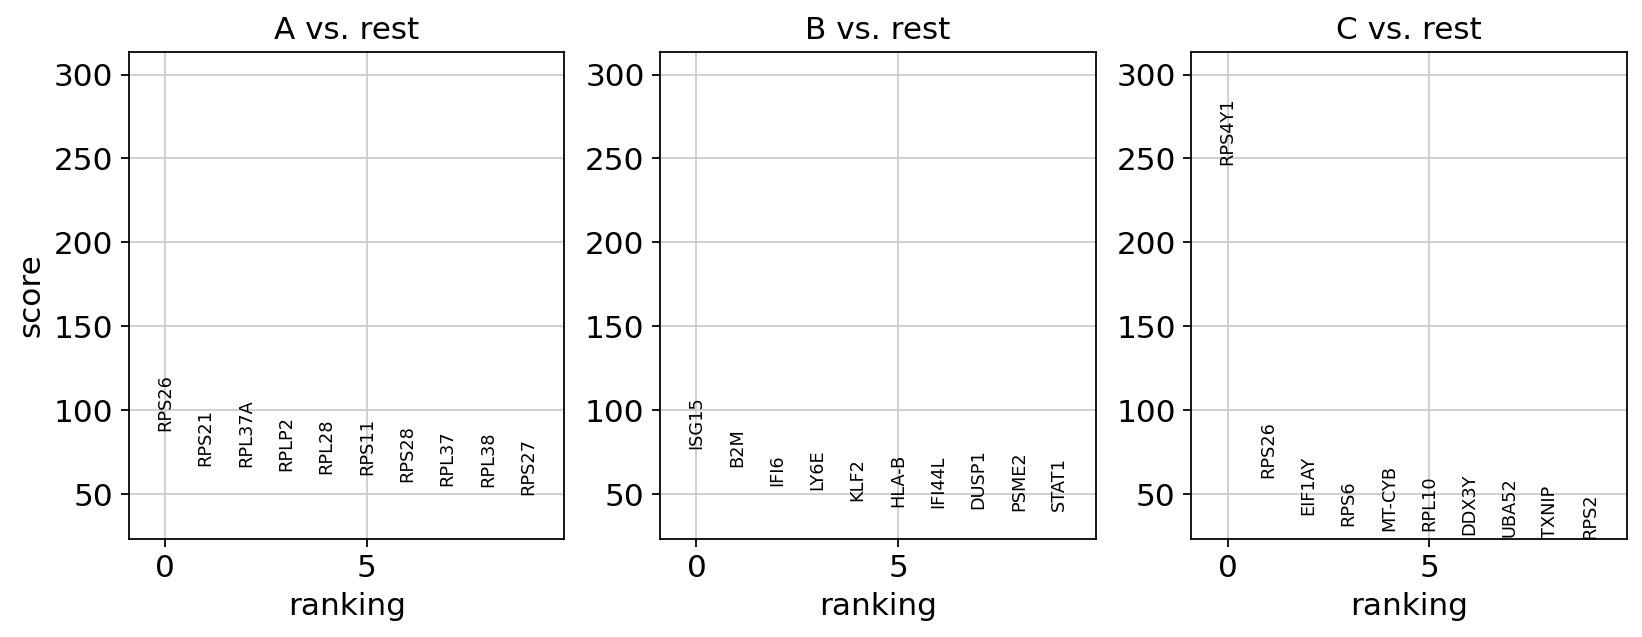

In [34]:
sc.pl.rank_genes_groups(samp_adata, n_genes=10)

In [35]:
donors = samp_adata.uns['rank_genes_groups']['names'].dtype.names

In [36]:
result = samp_adata.uns['rank_genes_groups']

In [37]:
import numpy as np

out = np.array([[0, 0, 0, 0, 0, 0]])

for donor in donors:
    out = np.vstack((out, np.vstack((result['names'][donor],
                                     np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                                     result['scores'][donor],
                                     result['pvals_adj'][donor],
                                     result['logfoldchanges'][donor],
                                     np.array([donor] * len(result['names'][donor])).astype('object'))).T))

In [38]:
out.shape

(42346, 6)

In [39]:
marker = pd.DataFrame(out[1:], columns=['Gene', 'Method', 'Score', 'pval_adj', 'lfc', 'Donor'])

In [40]:
marker

,Gene,Method,Score,pval_adj,lfc,Donor
0,RPS26,t-test,87.345917,0.0,3.480163,A
1,RPS21,t-test,66.959846,0.0,2.706165,A
2,RPL37A,t-test,66.124306,0.0,1.934813,A
3,RPLP2,t-test,63.60783,0.0,0.895487,A
4,RPL28,t-test,61.786419,0.0,0.843443,A
...,...,...,...,...,...,...
42340,XIST,t-test,-40.272892,0.0,-30.10107,C
42341,LY6E,t-test,-45.354565,0.0,-2.882358,C
42342,IFI6,t-test,-47.310837,0.0,-3.446244,C
42343,HLA-B,t-test,-48.409138,0.0,-0.950465,C


### Significant Gene Filtering

In [41]:
marker[(marker.pval_adj < 0.05) & (abs(marker.lfc) > 1)]

,Gene,Method,Score,pval_adj,lfc,Donor
0,RPS26,t-test,87.345917,0.0,3.480163,A
1,RPS21,t-test,66.959846,0.0,2.706165,A
2,RPL37A,t-test,66.124306,0.0,1.934813,A
5,RPS11,t-test,61.17094,0.0,2.247319,A
6,RPS28,t-test,57.338936,0.0,1.323088,A
...,...,...,...,...,...,...
42339,IFI44L,t-test,-38.927586,0.0,-4.366048,C
42340,XIST,t-test,-40.272892,0.0,-30.10107,C
42341,LY6E,t-test,-45.354565,0.0,-2.882358,C
42342,IFI6,t-test,-47.310837,0.0,-3.446244,C


In [42]:
HES4 = marker[marker['Gene'] == 'HES4']
HES4

,Gene,Method,Score,pval_adj,lfc,Donor
13624,HES4,t-test,-7.351394,0.0,-1.314983,A
14328,HES4,t-test,10.522793,0.0,1.48188,B
42048,HES4,t-test,-7.689606,0.0,-1.015507,C


In [43]:
# List of Scanpy methods for DGE analysis
methods = ['t-test', 'wilcoxon', 'logreg', 't-test_overestim_var']

# Create an empty DataFrame to store results
all_results = pd.DataFrame()

specific_celltype = 'T cell'
# specific_celltype = 'All'

for method in methods:
    print(f'===============================================\nPerforming {method}')
    
    sub_adata = adata.copy()

    if specific_celltype != 'All':
        sub_adata = sub_adata[sub_adata.obs['scsa_celltype_cellmarker'] == specific_celltype]        

    sc.tl.rank_genes_groups(sub_adata, groupby='donor', method=method)

    result = sub_adata.uns['rank_genes_groups']
    
    donors = result['names'].dtype.names

    out = np.array([[0, 0, 0, 0, 0, 0, 0]])
    
    for donor in donors:
        if 'pvals_adj' in result.keys():
            out = np.vstack(
                (out, np.vstack(
                    (result['names'][donor],
                     np.array([specific_celltype] * len(result['names'][donor])).astype('object'),
                     np.array([donor] * len(result['names'][donor])).astype('object'),
                     np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                     result['scores'][donor],
                     result['pvals_adj'][donor],
                     result['logfoldchanges'][donor],
                    )
                ).T)
            )
        else:
            out = np.vstack(
                (out, np.vstack(
                    (result['names'][donor],
                     np.array([specific_celltype] * len(result['names'][donor])).astype('object'),
                     np.array([donor] * len(result['names'][donor])).astype('object'),
                     np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                     result['scores'][donor],
                     np.array([np.NaN] * len(result['names'][donor])).astype('object'),
                     np.array([np.NaN] * len(result['names'][donor])).astype('object'),
                    )
                ).T)
            )    
        
    results_df = pd.DataFrame(out[1:], columns=['Gene', 'Target Cell Type', 'Donor', 'Method', 'Score', 'pval_adj', 'LFC'])
    all_results = pd.concat([all_results, results_df])
print("===============================================\nGenerating DataFrame")
all_results

Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:03)
Performing logreg
ranking genes
    finished (0:00:14)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame


,Gene,Target Cell Type,Donor,Method,Score,pval_adj,LFC
0,RPL28,T cell,A,t-test,61.66,0.0,0.707239
1,RPS26,T cell,A,t-test,57.455982,0.0,3.014933
2,RPLP2,T cell,A,t-test,57.23959,0.0,0.638701
3,RPL37A,T cell,A,t-test,56.61174,0.0,1.341861
4,RPS21,T cell,A,t-test,50.137348,0.0,1.842301
...,...,...,...,...,...,...,...
42340,IFITM2,T cell,C,t-test_overestim_var,-25.39036,0.0,-2.506362
42341,RPS4X,T cell,C,t-test_overestim_var,-25.968735,0.0,-0.2733
42342,ISG15,T cell,C,t-test_overestim_var,-30.689577,0.0,-3.252152
42343,HLA-B,T cell,C,t-test_overestim_var,-34.677948,0.0,-0.691222


In [44]:
all_results[all_results['Donor'] == 'A']

,Gene,Target Cell Type,Donor,Method,Score,pval_adj,LFC
0,RPL28,T cell,A,t-test,61.66,0.0,0.707239
1,RPS26,T cell,A,t-test,57.455982,0.0,3.014933
2,RPLP2,T cell,A,t-test,57.23959,0.0,0.638701
3,RPL37A,T cell,A,t-test,56.61174,0.0,1.341861
4,RPS21,T cell,A,t-test,50.137348,0.0,1.842301
...,...,...,...,...,...,...,...
14110,RPS4Y1,T cell,A,t-test_overestim_var,-43.479969,0.0,-35.171238
14111,DUSP1,T cell,A,t-test_overestim_var,-46.913189,0.0,-6.125834
14112,B2M,T cell,A,t-test_overestim_var,-50.799469,0.0,-0.883983
14113,MALAT1,T cell,A,t-test_overestim_var,-51.908161,0.0,-0.921645


In [45]:
all_results.to_csv(f'DEG_{specific_celltype}.csv', index=False)

In [53]:
adata.X.get_shape()

(19594, 2000)